## Improting Required libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import glob
import numpy as np
import asrpy

## Enabling CUDA use for MNE

In [2]:
mne.utils.set_config('MNE_USE_CUDA', 'true')

## Reading Dataset
We are reading four different kinds of datasets depicting 
- Heartfulness Meditation (htr)
- Concentration Meditation (ctr)
- Vipassana Meditation (vip)
- Sahaja Yoga Meditation (sny)

respectively.

In [3]:
%%capture

# To avoid unneccesary writing
htr_med1_data = []
ctr_med1_data = []
tm_med1_data  = []
vip_med1_data = []
sny_med1_data = []

raw_data  =[]

# Types of data (for task-wise analysis)
data_we_need = ['015', '026', '062', '080']

index = 0

# Getting whole med1 data for subject-wise analysis
for file in sorted(glob.glob('../sub-*/eeg/sub-*_task-med1breath_eeg.bdf')):
    try:
        data = mne.io.read_raw_bdf(file, preload=True)
        times = data.times
        duration = times[-1] - times[0]
        # Getting only data greater than or equal to 10 minues
        if duration >= 600:
            if index >= 0 and index < 24:
                htr_med1_data.append(data)
            elif index >= 24 and index < 56:
                ctr_med1_data.append(data)
            elif index >= 56 and index < 60:
                tm_med1_data.append(data)
            elif index >= 60 and index < 79:
                vip_med1_data.append(data)
            elif index >= 79 and index < 98:
                sny_med1_data.append(data)
    except:
        print(file + "not loaded")
    index += 1

# Getting data for task-wise analysis
for subject_number in data_we_need:
    for file in sorted(glob.glob('../sub-'+subject_number+'/eeg/*.bdf')):
        try:
            data = mne.io.read_raw_bdf(file, preload=True)
            times = data.times
            duration = times[-1] - times[0]
            # Getting onnly data greater than or equal to 10 minutes
            if duration >= 600:
                raw_data.append(data)
        except:
            print(name +" not loaded")

med1 = [0, 4, 8, 12]
med2 = [1, 5, 9, 13]
think1 = [2, 6, 10, 14]
think2 = [3, 7, 11, 15]

len(htr_med1_data), len(ctr_med1_data), len(vip_med1_data), len(sny_med1_data)

## Preprocessing Data
In this process, we will extract the necessary duration of data required and perform data cleaning to remove any artifacts.
- Cropping data
- Filtering data (notch filter and bandpass filter)
- Applying ICA

In [4]:
# Croping Data 
# Considering only first 10 minutes
cropped_raw_data = []
cropped_htr_med1_data = []
cropped_ctr_med1_data = []
cropped_vip_med1_data = []
cropped_sny_med1_data = []

for files in raw_data:
    cropped_raw_data.append(files.crop(tmin=0.0, tmax=600.0))

for files in htr_med1_data:
    cropped_htr_med1_data.append(files.crop(tmin=0.0, tmax=600.0))
for files in ctr_med1_data:
    cropped_ctr_med1_data.append(files.crop(tmin=0.0, tmax=600.0))
for files in vip_med1_data:
    cropped_vip_med1_data.append(files.crop(tmin=0.0, tmax=600.0))
for files in sny_med1_data:
    cropped_sny_med1_data.append(files.crop(tmin=0.0, tmax=600.0))

### Downsampling data

In [5]:
%%capture

# Downsampling data to 256 Hz
raw_resampled = [raw_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for raw_data in cropped_raw_data]

# Downsampling data to 256 Hz
htr_med1_resampled = [med1_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for med1_data in cropped_htr_med1_data]
ctr_med1_resampled = [med1_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for med1_data in cropped_ctr_med1_data]
vip_med1_resampled = [med1_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for med1_data in cropped_vip_med1_data]
sny_med1_resampled = [med1_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for med1_data in cropped_sny_med1_data]

In [6]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs="cuda")

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [7]:
# Channels
np.array(raw_data[0].ch_names).reshape(1, 73)

array([['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
        'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
        'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
        'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
        'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
        'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
        'P10', 'PO8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4',
        'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']], dtype='<U6')

In [8]:
%%capture

# Filtering data
filtered_data = []
filtered_htr_med1_data = []
filtered_ctr_med1_data = []
filtered_vip_med1_data = []
filtered_sny_med1_data = []

for data in raw_resampled:
    filtered_data.append(get_filtered_eeg(data))

for data in htr_med1_resampled:
    filtered_htr_med1_data.append(get_filtered_eeg(data))
for data in ctr_med1_resampled:
    filtered_ctr_med1_data.append(get_filtered_eeg(data))
for data in vip_med1_resampled:
    filtered_vip_med1_data.append(get_filtered_eeg(data))
for data in sny_med1_resampled:
    filtered_sny_med1_data.append(get_filtered_eeg(data))

Using matplotlib as 2D backend.


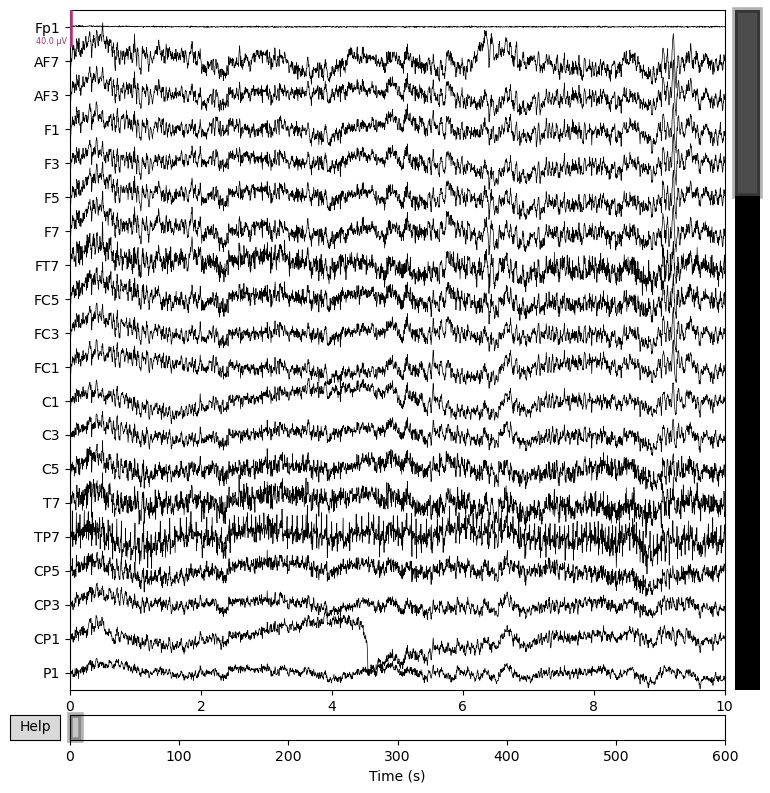

In [9]:
filtered_data[0].plot();

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_3132769/2036467727.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)


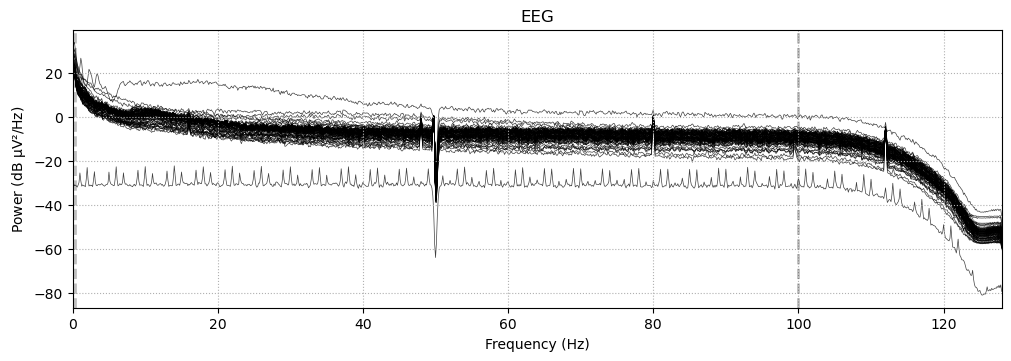

In [10]:
filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)

## Time-Frequency Analysis

In [11]:
from mne.time_frequency import tfr_morlet

### Events trick

As we are not having events in stimulus channels we are defining our own fake events.

In [39]:
# Define artificial events
event_id = dict(whole_data=1)  # Event ID for the artificial events
event_duration = 600  # Duration in seconds

# Create events array
# n_events = int(filtered_data[0].times[-1] // event_duration)
# events = np.zeros((n_events, 3), int)
# events[:, 0] = np.arange(n_events) * event_duration * filtered_data[0].info['sfreq']
# events[:, 2] = event_id
events = np.array([[0, 0, 1]])

In [13]:
# Create epochs
tmin = 0  # Start time before the event
tmax = data.times[-1]  # End time after the event
## Epochs for all 16 sets
epochs_list = [mne.Epochs(data, events, event_id, tmin,tmax, baseline=None, preload=True) for data in filtered_data]

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points 

KeyboardInterrupt: 

### Applying morlet transformation on each epoch for each data

In [ ]:
%%capture

# Define frequencies of interest and number of cycles
frequencies = np.arange(8, 30, 1)  # Example frequencies of interest
n_cycles = frequencies / 5.  # Define number of cycles per frequency

# Compute time-frequency representation
power, itc = [], []
for epochs in epochs_list:
    p, i = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, use_fft=True,
                                        return_itc=True, decim=3, n_jobs=20, average=True)
    power.append(p)
    itc.append(i)

## Power Spectral Density(PSD)

In [36]:
%%capture

htr_med1_psdDatas, psdFreqs = [],  []
ctr_med1_psdDatas =  []
vip_med1_psdDatas = []
sny_med1_psdDatas = []
for data in filtered_htr_med1_data:
    data.set_eeg_reference(ref_channels=['EXG8'])
    htr_med1_psdData, psdFreq = data.compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    htr_med1_psdDatas.append(htr_med1_psdData)
    psdFreqs.append(psdFreq)
for data in filtered_ctr_med1_data:
    data.set_eeg_reference(ref_channels=['EXG8'])
    ctr_med1_psdData, psdFreq = data.compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    ctr_med1_psdDatas.append(ctr_med1_psdData)
    psdFreqs.append(psdFreq)
for data in filtered_vip_med1_data:
    data.set_eeg_reference(ref_channels=['EXG8'])
    vip_med1_psdData, psdFreq = data.compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    vip_med1_psdDatas.append(vip_med1_psdData)
    psdFreqs.append(psdFreq)
for data in filtered_sny_med1_data:
    data.set_eeg_reference(ref_channels=['EXG8'])
    sny_med1_psdData, psdFreq = data.compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    sny_med1_psdDatas.append(sny_med1_psdData)
    psdFreqs.append(psdFreq)

In [37]:
htr_avg = np.mean(htr_med1_psdData, axis=0)
ctr_avg = np.mean(ctr_med1_psdData, axis=0)
vip_avg = np.mean(vip_med1_psdData, axis=0)
sny_avg = np.mean(sny_med1_psdData, axis=0)

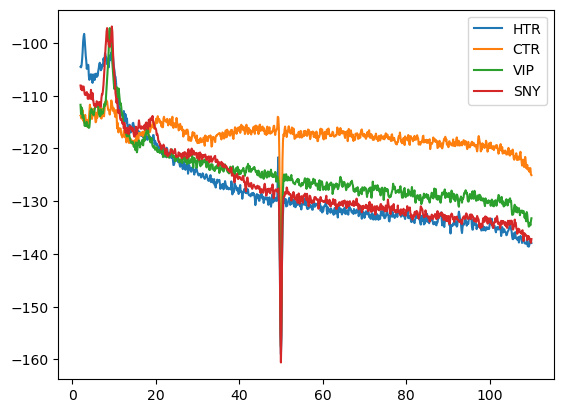

In [38]:
plt.clf()

shift_med1 = 0
# Med1
plt.plot(psdFreq, 10*np.log10(htr_avg) - shift_med1);
plt.plot(psdFreq, 10*np.log10(ctr_avg) - shift_med1);
plt.plot(psdFreq, 10*np.log10(vip_avg) - shift_med1);
plt.plot(psdFreq, 10*np.log10(sny_avg) - shift_med1);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

## Removing pink noise
In this section, we will remove 1/f or pink or fatal noise from our data

In [ ]:
def power_law(x, a, b):
    return a * (x ** (-b))

In [ ]:
from scipy.optimize import curve_fit

# Select the tail region for fitting
tail_fraction = 0.6
tail_start_index = int((1 - tail_fraction) * len(psdFreqs[0]))

x_tail = psdFreqs[0][tail_start_index:]
y_tail = (10*np.log10(psdDatas[2][0]) - shift_med1)[tail_start_index:]

popt, _ = curve_fit(power_law, x_tail, y_tail)
a, b = popt

y_fit = power_law(psdFreqs[0], a, b)

# # Plot the fitted curve on top of the original data
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1, label='Original Data with 1/f Noise');
plt.plot(psdFreq, y_fit, label='Original Data with 1/f Noise');
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1 - y_fit, label='Corrected Data with 1/f Noise');
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show();


### Ploting power and itc spectrum

In [ ]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10));
im1 = ax1.imshow((psdFreqs[0], (10*np.log10(psdDatas[3][0]) - shift_med1)),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
im2 = ax2.imshow((psdFreqs[0], 10*np.log10(psdDatas[3][0]) - shift_med1 - y_fit),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
plt.tight_layout()
plt.show()